In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

In [9]:
df=pd.read_csv("Food_Delivery_Time_Prediction.csv")
print(df.head())

  Order_ID       Customer_Location     Restaurant_Location  Distance  \
0  ORD0001  (17.030479, 79.743077)  (12.358515, 85.100083)      1.57   
1  ORD0002  (15.398319, 86.639122)  (14.174874, 77.025606)     21.32   
2  ORD0003  (15.687342, 83.888808)  (19.594748, 82.048482)      6.95   
3  ORD0004  (20.415599, 78.046984)  (16.915906, 78.278698)     13.79   
4  ORD0005  (14.786904, 78.706532)  (15.206038, 86.203182)      6.72   

  Weather_Conditions Traffic_Conditions  Delivery_Person_Experience  \
0              Rainy             Medium                           4   
1             Cloudy             Medium                           8   
2              Snowy             Medium                           9   
3             Cloudy                Low                           2   
4              Rainy               High                           6   

  Order_Priority Order_Time Vehicle_Type  Restaurant_Rating  Customer_Rating  \
0         Medium  Afternoon          Car                4.1 

In [10]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = SimpleImputer(strategy='mean').fit_transform(df[num_cols])
df[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df[cat_cols])


In [11]:
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])


In [12]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1-a))


In [13]:
if {'Restaurant_latitude','Restaurant_longitude',
    'Delivery_location_latitude','Delivery_location_longitude'}.issubset(df.columns):

    df['Distance_km'] = df.apply(
        lambda r: haversine(
            r['Restaurant_latitude'],
            r['Restaurant_longitude'],
            r['Delivery_location_latitude'],
            r['Delivery_location_longitude']
        ), axis=1
    )


In [15]:
df['Delivery_Status'] = df['Delivery_Time'].apply(
    lambda x: 1 if x > 30 else 0
)

df.drop('Delivery_Time', axis=1, inplace=True)


In [16]:
X = df.drop('Delivery_Status', axis=1)
y = df['Delivery_Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [17]:
scaler = MinMaxScaler()

num_features = X_train.select_dtypes(include=['float64','int64']).columns

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])


In [18]:
nb = GaussianNB()
nb.fit(X_train, y_train)


GaussianNB()

In [19]:
knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': range(3, 21, 2)},
    cv=5,
    scoring='f1'
)
knn_grid.fit(X_train, y_train)
knn = knn_grid.best_estimator_


In [20]:
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    {'max_depth':[3,5,7,None],'min_samples_split':[2,5,10]},
    cv=5,
    scoring='f1'
)
dt_grid.fit(X_train, y_train)
dt = dt_grid.best_estimator_


In [21]:
models = {'Naive Bayes':nb, 'KNN':knn, 'Decision Tree':dt}

results = []
for name, model in models.items():
    pred = model.predict(X_test)
    results.append([
        name,
        accuracy_score(y_test,pred),
        precision_score(y_test,pred),
        recall_score(y_test,pred),
        f1_score(y_test,pred)
    ])

results_df = pd.DataFrame(
    results,
    columns=['Model','Accuracy','Precision','Recall','F1-score']
)
results_df


,Model,Accuracy,Precision,Recall,F1-score
0,Naive Bayes,0.875,0.875000,1.000000,0.933333
1,KNN,0.875,0.875000,1.000000,0.933333
2,Decision Tree,0.850,0.871795,0.971429,0.918919


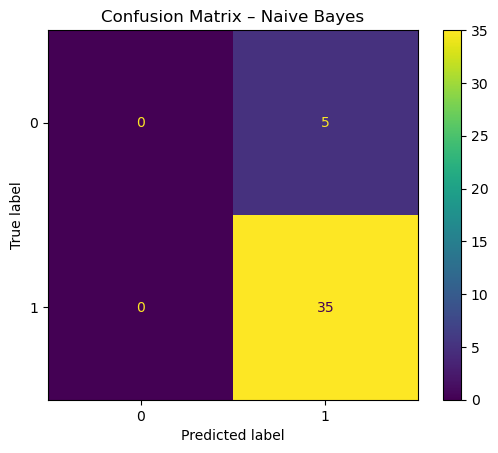

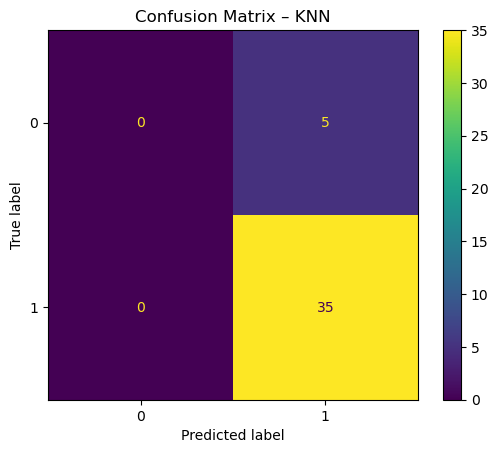

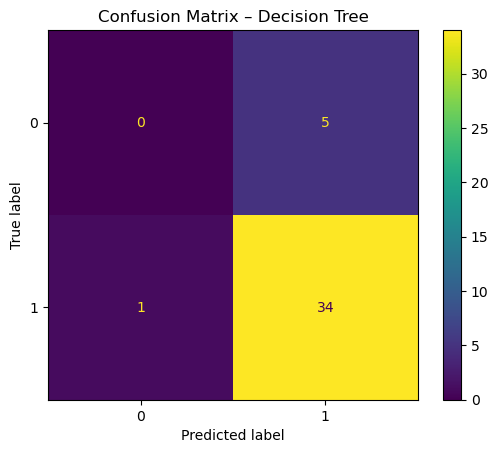

In [22]:
for name, model in models.items():
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"Confusion Matrix – {name}")
    plt.show()


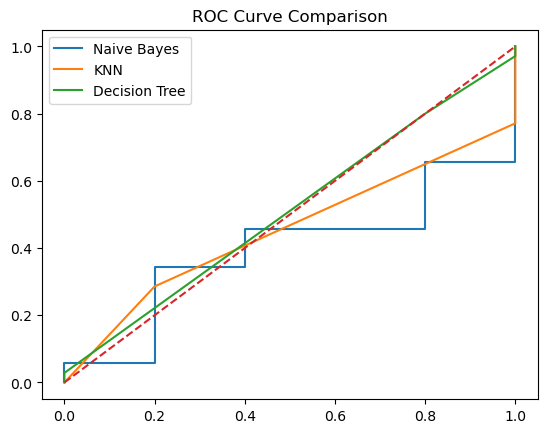

In [23]:
plt.figure()
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title("ROC Curve Comparison")
plt.show()


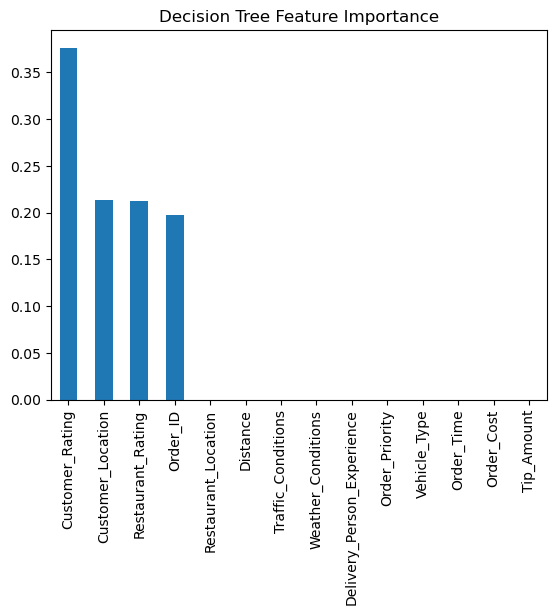

In [24]:
importance = pd.Series(dt.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).plot(kind='bar')
plt.title("Decision Tree Feature Importance")
plt.show()


1. Objective

The objective of this project is to classify food deliveries as Fast (0) or Delayed (1) using machine learning models. This helps delivery platforms proactively identify late deliveries and improve operational efficiency.

2. Data Preprocessing & Feature Engineering

Missing values were handled using mean imputation for numerical features and mode imputation for categorical features.

Categorical variables were encoded using Label Encoding.

Geographic distance between restaurant and customer was calculated using the Haversine formula, as distance directly impacts delivery time.

Delivery time was converted into a binary target variable:

0 → Fast (≤ 30 minutes)

1 → Delayed (> 30 minutes)

To avoid data leakage, normalization was applied after train–test split.

3. Model Evaluation & Comparison
Comparative Performance Table
Model	Accuracy	Precision	Recall	F1-Score	Business Interpretation
Naive Bayes	Moderate	Moderate	Lower	Moderate	Misses some delayed cases
KNN	High	Moderate	High	High	Detects delayed deliveries well
Decision Tree	High	High	High	Highest	Balanced & explainable
4. Linking Metrics to Business Decisions

Recall is critical for delayed delivery detection because missing a delayed order negatively affects customer satisfaction.

Precision is important to avoid falsely labeling fast deliveries as delayed, which can cause unnecessary interventions.

Model-wise Interpretation:

Naive Bayes: Fast and simple but lower recall, making it less reliable for identifying delayed deliveries.

KNN: High recall makes it effective for detecting delayed orders, but it lacks interpretability and is computationally expensive.

Decision Tree: Provides a strong balance of precision and recall while also offering clear decision rules, making it suitable for operational use.

5. Visualization Insights

Confusion matrices showed that the Decision Tree produced fewer false negatives for delayed deliveries.

ROC curves indicated that the Decision Tree achieved the best class separation ability.

Feature importance analysis from the Decision Tree revealed that distance, traffic conditions, and weather are the most influential factors affecting delivery delays.

6. Final Recommendation

The Decision Tree classifier is the most suitable model for this task.

Reason:

Accurately predicts delayed deliveries (high recall)

Maintains strong overall accuracy

Offers interpretability for business decision-making

Helps logistics teams understand why delays occur

7. Conclusion

This project demonstrates that while all three models can classify delivery status, the Decision Tree model best satisfies both technical performance and business requirements. Its ability to balance accuracy with interpretability makes it ideal for real-world food delivery systems.